## Utilizing PyOD for Deep Learning Model Selection with GPT Few-Shot Learning

### Project Overview
This project leverages the Python Outlier Detection (PyOD) library, which encompasses a wide range of deep learning models designed for identifying outliers in multivariate data. Our goal is to use this extensive toolkit in conjunction with a language model (GPT) to intelligently select the most appropriate model for a specific dataset through a few-shot learning approach.

### Objectives
1. **Summarize Dataset and Model Information**: Compile and format detailed information about our dataset and the available models within the PyOD library into a structured form that can be easily processed by GPT.
2. **Model Selection with Language Model (LLM)**: Utilize the capabilities of GPT, trained in a few-shot learning manner, to determine the most suitable outlier detection model from the PyOD library for our dataset based on the summarized information.

### Dataset Description
The dataset involved in this project is characterized by its diversity in features and instances, providing a challenging environment to test the efficacy of various outlier detection models. Here’s a brief overview of the dataset:

| Dataset    | Domain            | Data Type    | Instances | Attributes | Missing Values | Area                    |
|------------|-------------------|--------------|-----------|------------|----------------|-------------------------|
| Arrhythmia | Medical           | Multivariate | 452       | 279        | Yes            | Cardiology              |
| Glass      | Forensic Science  | Multivariate | 214       | 9          | No             | Material Identification |
| Ionosphere | Astronomy         | Multivariate | 351       | 34         | No             | Space                   |
| Lympho     | Medical           | Multivariate | 148       | 18         | No             | Oncology                |


### PyOD Models Overview
The PyOD library includes several deep learning-based models, each with unique capabilities and configurations. The following table summarizes some of the models available for selection:

| Model      | Description                                                                                           |
|------------|-------------------------------------------------------------------------------------------------------|
| MO_GAAL    | Multiple-Objective Generative Adversarial Active Learning, suitable for complex multi-objective setups. |
| SO_GAAL    | Single-Objective Generative Adversarial Active Learning, optimized for simpler, single-objective tasks.  |
| AutoEncoder| Utilizes neural networks to learn compressed data representations, detecting anomalies based on the reconstruction errors. |
| AnoGAN     | Anomaly Detection with Generative Adversarial Networks, employs a discriminator to identify data inconsistencies. |
| DeepSVDD   | Deep Support Vector Data Description, a deep learning adaptation of the traditional SVDD method.     |
| ALAD       | Adversarially Learned Anomaly Detection, differentiates normal from abnormal data in latent space using adversarial training. |





In [1]:
from __future__ import division
from __future__ import print_function

import os
import sys
from time import time

import json

# temporary solution for relative imports in case pyod is not installed
# if pyod is installed, no need to use the following line
sys.path.append(
    os.path.abspath(os.path.join(os.path.dirname("__file__"), '..')))
# supress warnings for clean output
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.io import loadmat

# DL models in pyod
from pyod.models.mo_gaal import MO_GAAL
from pyod.models.so_gaal import SO_GAAL
from pyod.models.auto_encoder import AutoEncoder
from pyod.models.vae import VAE
from pyod.models.anogan import AnoGAN
from pyod.models.deep_svdd import DeepSVDD
from pyod.models.alad import ALAD
from pyod.models.ae1svm import AE1SVM
from pyod.models.devnet import DevNet
from pyod.models.rgraph import RGraph
from pyod.models.lunar import LUNAR


from pyod.utils.utility import standardizer
from pyod.utils.utility import precision_n_scores
from sklearn.metrics import roc_auc_score



In [ ]:
# Define data file and read X and y
mat_file_list = ['arrhythmia.mat',
                 'cardio.mat',
                'glass.mat',
                 'ionosphere.mat',
                 'letter.mat',
                 'lympho.mat',
                 'mnist.mat',
                  'musk.mat',
                  'optdigits.mat',
                  'pendigits.mat',
                  'pima.mat',
                  'satellite.mat',
                  'satimage-2.mat',
                  'shuttle.mat',
                  'vertebral.mat',
                  'vowels.mat',
                 'wbc.mat'
                 ]

# Define outlier detection tools to be compared
random_state = np.random.RandomState(42)

#待添加：VAE
df_columns = ['Data', '#Samples', '# Dimensions', 'Outlier Perc',
              'MO_GAAL', 
              'SO_GAAL', 
              'AutoEncoder', 
              'AnoGAN', 
              'DeepSVDD', 
              'ALAD', 
              'AE1SVM', 
              'DevNet', 
              'RGraph', 
              'LUNAR'
              ]
roc_df = pd.DataFrame(columns=df_columns)
prn_df = pd.DataFrame(columns=df_columns)
time_df = pd.DataFrame(columns=df_columns)

for mat_file in mat_file_list:
    print("\n... Processing", mat_file, '...')
    mat = loadmat(os.path.join('data', mat_file))

    X = mat['X']
    y = mat['y'].ravel()
    outliers_fraction = np.count_nonzero(y) / len(y)
    outliers_percentage = round(outliers_fraction * 100, ndigits=4)
    n_features = X.shape[1]

    col_means = np.nanmean(X, axis=0)
    inds = np.where(np.isnan(X))
    X[inds] = np.take(col_means, inds[1])

    if np.isnan(X).any():
        raise ValueError("NaN values remain after attempting to replace with column means.")

    # Construct containers for saving results
    roc_list = [mat_file[:-4], X.shape[0], X.shape[1], outliers_percentage]
    prn_list = [mat_file[:-4], X.shape[0], X.shape[1], outliers_percentage]
    time_list = [mat_file[:-4], X.shape[0], X.shape[1], outliers_percentage]

    # 60% data for training and 40% for testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=random_state)

    # Standardizing data for processing
    X_train_norm, X_test_norm = standardizer(X_train, X_test)

    classifiers = {
        'MO_GAAL': MO_GAAL(contamination=outliers_fraction),
        'SO_GAAL': SO_GAAL(contamination=outliers_fraction),
       'AutoEncoder': AutoEncoder(contamination=outliers_fraction),
        'VAE': VAE(contamination=outliers_fraction),
        'AnoGAN': AnoGAN(contamination=outliers_fraction),
        'DeepSVDD': DeepSVDD(contamination=outliers_fraction, n_features=n_features),
        'ALAD': ALAD(contamination=outliers_fraction),
        'AE1SVM': AE1SVM(contamination=outliers_fraction),
        'DevNet': DevNet(contamination=outliers_fraction),
        'RGraph': RGraph(contamination=outliers_fraction),
      'LUNAR': LUNAR(contamination=outliers_fraction)
    }

    for clf_name, clf in classifiers.items():
        t0 = time()
        if clf_name == 'DevNet':
            clf.fit(X_train_norm, y_train)
        else:
            clf.fit(X_train_norm)
        test_scores = clf.decision_function(X_test_norm)
        t1 = time()
        duration = round(t1 - t0, ndigits=4)
        time_list.append(duration)

        roc = round(roc_auc_score(y_test, test_scores), ndigits=4)
        prn = round(precision_n_scores(y_test, test_scores), ndigits=4)

        print(f'{clf_name} ROC: {roc}, precision @ rank n: {prn}, execution time: {duration}s')

        roc_list.append(roc)
        prn_list.append(prn)

    temp_df = pd.DataFrame(time_list).transpose()
    temp_df.columns = df_columns
    time_df = pd.concat([time_df, temp_df], axis=0)

    temp_df = pd.DataFrame(roc_list).transpose()
    temp_df.columns = df_columns
    roc_df = pd.concat([roc_df, temp_df], axis=0)

    temp_df = pd.DataFrame(prn_list).transpose()
    temp_df.columns = df_columns
    prn_df = pd.concat([prn_df, temp_df], axis=0)


... Processing arrhythmia.mat ...
Epoch 1 of 60
Epoch 2 of 60
Epoch 3 of 60
Epoch 4 of 60
Epoch 5 of 60
Epoch 6 of 60
Epoch 7 of 60
Epoch 8 of 60
Epoch 9 of 60
Epoch 10 of 60
Epoch 11 of 60
Epoch 12 of 60
Epoch 13 of 60
Epoch 14 of 60
Epoch 15 of 60
Epoch 16 of 60
Epoch 17 of 60
Epoch 18 of 60
Epoch 19 of 60
Epoch 20 of 60
Epoch 21 of 60
Epoch 22 of 60
Epoch 23 of 60
Epoch 24 of 60
Epoch 25 of 60
Epoch 26 of 60
Epoch 27 of 60
Epoch 28 of 60
Epoch 29 of 60
Epoch 30 of 60
Epoch 31 of 60
Epoch 32 of 60
Epoch 33 of 60
Epoch 34 of 60
Epoch 35 of 60
Epoch 36 of 60
Epoch 37 of 60
Epoch 38 of 60
Epoch 39 of 60
Epoch 40 of 60
Epoch 41 of 60
Epoch 42 of 60
Epoch 43 of 60
Epoch 44 of 60
Epoch 45 of 60
Epoch 46 of 60
Epoch 47 of 60
Epoch 48 of 60
Epoch 49 of 60
Epoch 50 of 60
Epoch 51 of 60
Epoch 52 of 60
Epoch 53 of 60
Epoch 54 of 60
Epoch 55 of 60
Epoch 56 of 60
Epoch 57 of 60
Epoch 58 of 60
Epoch 59 of 60
Epoch 60 of 60
MO_GAAL ROC: 0.6153, precision @ rank n: 0.3214, execution time: 2.5377s
E

Training: 100%|██████████| 10/10 [00:00<00:00, 17.74it/s]


AutoEncoder ROC: 0.8096, precision @ rank n: 0.3929, execution time: 2.6698s
AnoGAN ROC: 0.7726, precision @ rank n: 0.4286, execution time: 47.7989s
Epoch 1/100, Loss: 5.825584053993225
Epoch 2/100, Loss: 5.766186058521271
Epoch 3/100, Loss: 5.762155622243881
Epoch 4/100, Loss: 5.853882700204849
Epoch 5/100, Loss: 5.786322772502899
Epoch 6/100, Loss: 5.646298587322235
Epoch 7/100, Loss: 5.793177425861359
Epoch 8/100, Loss: 5.740046471357346
Epoch 9/100, Loss: 5.9401843547821045
Epoch 10/100, Loss: 5.7085913717746735
Epoch 11/100, Loss: 5.576205193996429
Epoch 12/100, Loss: 5.7851404547691345
Epoch 13/100, Loss: 5.77113077044487
Epoch 14/100, Loss: 5.7520412504673
Epoch 15/100, Loss: 5.915862739086151
Epoch 16/100, Loss: 5.660930097103119
Epoch 17/100, Loss: 5.639804899692535
Epoch 18/100, Loss: 5.746669828891754
Epoch 19/100, Loss: 5.6973293125629425
Epoch 20/100, Loss: 5.6578125059604645
Epoch 21/100, Loss: 5.895969212055206
Epoch 22/100, Loss: 6.077497363090515
Epoch 23/100, Loss: 5

Training: 100%|██████████| 10/10 [00:01<00:00,  7.30it/s]


AutoEncoder ROC: 0.8035, precision @ rank n: 0.4143, execution time: 1.4345s
AnoGAN ROC: 0.8117, precision @ rank n: 0.3571, execution time: 101.8575s
Epoch 1/100, Loss: 34.254013776779175
Epoch 2/100, Loss: 34.26036238670349
Epoch 3/100, Loss: 34.827121794223785
Epoch 4/100, Loss: 34.77704191207886
Epoch 5/100, Loss: 34.10073971748352
Epoch 6/100, Loss: 34.29127871990204
Epoch 7/100, Loss: 35.165798008441925
Epoch 8/100, Loss: 34.22008377313614
Epoch 9/100, Loss: 34.24218159914017
Epoch 10/100, Loss: 34.3473886847496
Epoch 11/100, Loss: 34.585757076740265
Epoch 12/100, Loss: 34.25657516717911
Epoch 13/100, Loss: 34.17445981502533
Epoch 14/100, Loss: 34.47404384613037
Epoch 15/100, Loss: 34.23478227853775
Epoch 16/100, Loss: 34.50931680202484
Epoch 17/100, Loss: 34.180251121520996
Epoch 18/100, Loss: 34.86162233352661
Epoch 19/100, Loss: 34.10597777366638
Epoch 20/100, Loss: 34.34543818235397
Epoch 21/100, Loss: 33.998432993888855
Epoch 22/100, Loss: 34.82766270637512
Epoch 23/100, Los

Training: 100%|██████████| 10/10 [00:00<00:00, 58.08it/s]


AutoEncoder ROC: 0.6099, precision @ rank n: 0.2, execution time: 0.1851s
AnoGAN ROC: 0.7136, precision @ rank n: 0.2, execution time: 12.4549s
Epoch 1/100, Loss: 3.3433185815811157
Epoch 2/100, Loss: 3.3433185517787933
Epoch 3/100, Loss: 3.343318521976471
Epoch 4/100, Loss: 3.3433186411857605
Epoch 5/100, Loss: 3.3433187007904053
Epoch 6/100, Loss: 3.3433186411857605
Epoch 7/100, Loss: 3.34331876039505
Epoch 8/100, Loss: 3.3433187007904053
Epoch 9/100, Loss: 3.34331876039505
Epoch 10/100, Loss: 3.3433185815811157
Epoch 11/100, Loss: 3.3433186411857605
Epoch 12/100, Loss: 3.343318670988083
Epoch 13/100, Loss: 3.3433187007904053
Epoch 14/100, Loss: 3.3433186411857605
Epoch 15/100, Loss: 3.34331876039505
Epoch 16/100, Loss: 3.3433185815811157
Epoch 17/100, Loss: 3.3433185815811157
Epoch 18/100, Loss: 3.3433186411857605
Epoch 19/100, Loss: 3.343318462371826
Epoch 20/100, Loss: 3.343318521976471
Epoch 21/100, Loss: 3.3433187007904053
Epoch 22/100, Loss: 3.343318670988083
Epoch 23/100, Loss

Training: 100%|██████████| 10/10 [00:00<00:00, 39.82it/s]


AutoEncoder ROC: 0.7586, precision @ rank n: 0.5435, execution time: 0.2691s
AnoGAN ROC: 0.6828, precision @ rank n: 0.413, execution time: 23.8715s
Epoch 1/100, Loss: 8.3324373960495
Epoch 2/100, Loss: 8.115451455116272
Epoch 3/100, Loss: 8.105461061000824
Epoch 4/100, Loss: 8.293000519275665
Epoch 5/100, Loss: 7.890415608882904
Epoch 6/100, Loss: 8.086254358291626
Epoch 7/100, Loss: 8.180583536624908
Epoch 8/100, Loss: 8.07235562801361
Epoch 9/100, Loss: 8.18907344341278
Epoch 10/100, Loss: 8.313003063201904
Epoch 11/100, Loss: 8.128568172454834
Epoch 12/100, Loss: 8.103331923484802
Epoch 13/100, Loss: 7.952325880527496
Epoch 14/100, Loss: 8.246003687381744
Epoch 15/100, Loss: 8.119832396507263
Epoch 16/100, Loss: 8.198503732681274
Epoch 17/100, Loss: 8.021750688552856
Epoch 18/100, Loss: 8.144030690193176
Epoch 19/100, Loss: 8.251888930797577
Epoch 20/100, Loss: 8.197829484939575
Epoch 21/100, Loss: 8.015553414821625
Epoch 22/100, Loss: 8.051014184951782
Epoch 23/100, Loss: 7.860401

Training: 100%|██████████| 10/10 [00:01<00:00,  8.74it/s]


AutoEncoder ROC: 0.7909, precision @ rank n: 0.2439, execution time: 1.204s
AnoGAN ROC: 0.5222, precision @ rank n: 0.0488, execution time: 101.0979s
Epoch 1/100, Loss: 22.410838663578033
Epoch 2/100, Loss: 22.410838663578033
Epoch 3/100, Loss: 22.410838782787323
Epoch 4/100, Loss: 22.410838782787323
Epoch 5/100, Loss: 22.410838901996613
Epoch 6/100, Loss: 22.41083860397339
Epoch 7/100, Loss: 22.41083836555481
Epoch 8/100, Loss: 22.410838425159454
Epoch 9/100, Loss: 22.410838663578033
Epoch 10/100, Loss: 22.410838782787323
Epoch 11/100, Loss: 22.4108384847641
Epoch 12/100, Loss: 22.410838723182678
Epoch 13/100, Loss: 22.41083914041519
Epoch 14/100, Loss: 22.410838782787323
Epoch 15/100, Loss: 22.41083860397339
Epoch 16/100, Loss: 22.410838544368744
Epoch 17/100, Loss: 22.410838842391968
Epoch 18/100, Loss: 22.4108384847641
Epoch 19/100, Loss: 22.41083925962448
Epoch 20/100, Loss: 22.410838961601257
Epoch 21/100, Loss: 22.410838544368744
Epoch 22/100, Loss: 22.410838842391968
Epoch 23/1

Training: 100%|██████████| 10/10 [00:00<00:00, 114.24it/s]

AutoEncoder ROC: 0.9825, precision @ rank n: 0.6667, execution time: 0.0985s


AnoGAN ROC: 0.9883, precision @ rank n: 0.6667, execution time: 8.8289s
Epoch 1/100, Loss: 2.098798632621765
Epoch 2/100, Loss: 2.098392367362976
Epoch 3/100, Loss: 2.0825175642967224
Epoch 4/100, Loss: 2.056439757347107
Epoch 5/100, Loss: 2.106468081474304
Epoch 6/100, Loss: 2.080767869949341
Epoch 7/100, Loss: 2.114632546901703
Epoch 8/100, Loss: 2.128776967525482
Epoch 9/100, Loss: 2.0689841508865356
Epoch 10/100, Loss: 2.1475874185562134
Epoch 11/100, Loss: 2.0775773525238037
Epoch 12/100, Loss: 2.076535224914551
Epoch 13/100, Loss: 2.111051857471466
Epoch 14/100, Loss: 2.0623867511749268
Epoch 15/100, Loss: 2.0881545543670654
Epoch 16/100, Loss: 2.09485924243927
Epoch 17/100, Loss: 2.0764706134796143
Epoch 18/100, Loss: 2.050186574459076
Epoch 19/100, Loss: 2.0879068970680237
Epoch 20/100, Loss: 2.0831496715545654
Epoch 21/100, Loss: 2.065665304660797
Epoch 22/100, Loss: 2.103876531124115
Epoch 23/100, Loss: 2.1320374608039856
Epoch 24/100, Loss: 2.1184815168380737
Epoch 25/100, L

Training: 100%|██████████| 10/10 [00:06<00:00,  1.65it/s]


AutoEncoder ROC: 0.8356, precision @ rank n: 0.3667, execution time: 6.352s
AnoGAN ROC: 0.7216, precision @ rank n: 0.2741, execution time: 498.496s
Epoch 1/100, Loss: 100.48627677559853
Epoch 2/100, Loss: 100.45087614655495
Epoch 3/100, Loss: 100.43318963050842
Epoch 4/100, Loss: 100.36255493760109
Epoch 5/100, Loss: 100.40550136566162
Epoch 6/100, Loss: 100.43142592906952
Epoch 7/100, Loss: 100.41432133316994
Epoch 8/100, Loss: 100.53763690590858
Epoch 9/100, Loss: 100.56227323412895
Epoch 10/100, Loss: 100.35718056559563
Epoch 11/100, Loss: 100.43870276212692
Epoch 12/100, Loss: 100.39319637417793
Epoch 13/100, Loss: 100.49998757243156
Epoch 14/100, Loss: 100.48829102516174
Epoch 15/100, Loss: 100.38107052445412
Epoch 16/100, Loss: 100.39479210972786
Epoch 17/100, Loss: 100.40472730994225
Epoch 18/100, Loss: 100.3943273127079
Epoch 19/100, Loss: 100.41418677568436
Epoch 20/100, Loss: 100.67141166329384
Epoch 21/100, Loss: 100.36829018592834
Epoch 22/100, Loss: 100.7282617688179
Epoc

Training: 100%|██████████| 10/10 [00:02<00:00,  3.86it/s]


AutoEncoder ROC: 0.874, precision @ rank n: 0.3659, execution time: 2.7362s
AnoGAN ROC: 0.7973, precision @ rank n: 0.0976, execution time: 219.7535s
Epoch 1/100, Loss: 47.54626828432083
Epoch 2/100, Loss: 47.55983006954193
Epoch 3/100, Loss: 47.56163239479065
Epoch 4/100, Loss: 47.56049710512161
Epoch 5/100, Loss: 47.52530771493912
Epoch 6/100, Loss: 47.58374470472336
Epoch 7/100, Loss: 47.6689310669899
Epoch 8/100, Loss: 47.554724633693695
Epoch 9/100, Loss: 47.525734066963196
Epoch 10/100, Loss: 47.535117387771606
Epoch 11/100, Loss: 47.54128044843674
Epoch 12/100, Loss: 47.49360364675522
Epoch 13/100, Loss: 47.47156625986099
Epoch 14/100, Loss: 47.63751417398453
Epoch 15/100, Loss: 47.72647249698639
Epoch 16/100, Loss: 47.57332557439804
Epoch 17/100, Loss: 47.54338163137436
Epoch 18/100, Loss: 47.5374698638916
Epoch 19/100, Loss: 47.478346049785614
Epoch 20/100, Loss: 47.536720871925354
Epoch 21/100, Loss: 47.53050369024277
Epoch 22/100, Loss: 47.58979219198227
Epoch 23/100, Loss: 

Training: 100%|██████████| 10/10 [00:04<00:00,  2.30it/s]


AutoEncoder ROC: 0.4162, precision @ rank n: 0.0, execution time: 4.5439s
AnoGAN ROC: 0.8326, precision @ rank n: 0.0615, execution time: 365.5587s
Epoch 1/100, Loss: 84.7713680267334
Epoch 2/100, Loss: 84.81513863801956
Epoch 3/100, Loss: 84.7787544131279
Epoch 4/100, Loss: 84.86353874206543
Epoch 5/100, Loss: 84.79836690425873
Epoch 6/100, Loss: 84.79892635345459
Epoch 7/100, Loss: 84.77080225944519
Epoch 8/100, Loss: 84.81914788484573
Epoch 9/100, Loss: 84.7668809890747
Epoch 10/100, Loss: 84.79665470123291
Epoch 11/100, Loss: 84.74382972717285
Epoch 12/100, Loss: 84.77438217401505
Epoch 13/100, Loss: 84.79361826181412
Epoch 14/100, Loss: 84.78759407997131
Epoch 15/100, Loss: 84.7932915687561
Epoch 16/100, Loss: 84.80418872833252
Epoch 17/100, Loss: 84.81703251600266
Epoch 18/100, Loss: 84.81481325626373
Epoch 19/100, Loss: 84.79149639606476
Epoch 20/100, Loss: 84.7865993976593
Epoch 21/100, Loss: 85.13146489858627
Epoch 22/100, Loss: 84.77612775564194
Epoch 23/100, Loss: 84.7587245

Training: 100%|██████████| 10/10 [00:04<00:00,  2.13it/s]


AutoEncoder ROC: 0.85, precision @ rank n: 0.0968, execution time: 4.9295s
AnoGAN ROC: 0.9516, precision @ rank n: 0.2742, execution time: 432.2932s
Epoch 1/100, Loss: 100.64183348417282
Epoch 2/100, Loss: 100.64113879203796
Epoch 3/100, Loss: 100.66440373659134
Epoch 4/100, Loss: 100.64251136779785
Epoch 5/100, Loss: 100.63395762443542
Epoch 6/100, Loss: 100.61000764369965
Epoch 7/100, Loss: 100.636385679245
Epoch 8/100, Loss: 100.61257010698318
Epoch 9/100, Loss: 100.62919175624847
Epoch 10/100, Loss: 100.5830647945404
Epoch 11/100, Loss: 100.63739538192749
Epoch 12/100, Loss: 100.628446996212
Epoch 13/100, Loss: 100.6292222738266
Epoch 14/100, Loss: 100.63025486469269
Epoch 15/100, Loss: 100.62025445699692
Epoch 16/100, Loss: 100.64459389448166
Epoch 17/100, Loss: 100.6317201256752
Epoch 18/100, Loss: 100.6529877781868
Epoch 19/100, Loss: 100.62735515832901
Epoch 20/100, Loss: 100.61512023210526
Epoch 21/100, Loss: 100.62325137853622
Epoch 22/100, Loss: 100.65257412195206
Epoch 23/1

Training: 100%|██████████| 10/10 [00:00<00:00, 17.32it/s]


AutoEncoder ROC: 0.6848, precision @ rank n: 0.531, execution time: 0.6171s
AnoGAN ROC: 0.6082, precision @ rank n: 0.4867, execution time: 56.2928s
Epoch 1/100, Loss: 12.22780841588974
Epoch 2/100, Loss: 12.169927835464478
Epoch 3/100, Loss: 12.19047099351883
Epoch 4/100, Loss: 12.227613389492035
Epoch 5/100, Loss: 12.680608868598938
Epoch 6/100, Loss: 12.361464440822601
Epoch 7/100, Loss: 12.098161697387695
Epoch 8/100, Loss: 12.035441279411316
Epoch 9/100, Loss: 12.06643396615982
Epoch 10/100, Loss: 12.124643087387085
Epoch 11/100, Loss: 12.132115304470062
Epoch 12/100, Loss: 12.228932738304138
Epoch 13/100, Loss: 12.09403771162033
Epoch 14/100, Loss: 12.18231338262558
Epoch 15/100, Loss: 12.147866070270538
Epoch 16/100, Loss: 12.322079598903656
Epoch 17/100, Loss: 12.011357247829437
Epoch 18/100, Loss: 12.131879806518555
Epoch 19/100, Loss: 12.248028993606567
Epoch 20/100, Loss: 12.22016990184784
Epoch 21/100, Loss: 12.1084566116333
Epoch 22/100, Loss: 12.261483013629913
Epoch 23/1

Training: 100%|██████████| 10/10 [00:04<00:00,  2.40it/s]


AutoEncoder ROC: 0.6899, precision @ rank n: 0.5308, execution time: 4.409s
AnoGAN ROC: 0.7107, precision @ rank n: 0.5554, execution time: 648.8662s
Epoch 1/100, Loss: 120.85479295253754
Epoch 2/100, Loss: 120.79118996858597
Epoch 3/100, Loss: 120.94323629140854
Epoch 4/100, Loss: 121.01542687416077
Epoch 5/100, Loss: 120.87259921431541
Epoch 6/100, Loss: 120.99217683076859
Epoch 7/100, Loss: 120.9049921631813
Epoch 8/100, Loss: 120.88437750935555
Epoch 9/100, Loss: 120.96697825193405
Epoch 10/100, Loss: 120.91049337387085
Epoch 11/100, Loss: 120.93873339891434
Epoch 12/100, Loss: 120.80519354343414
Epoch 13/100, Loss: 120.89640289545059
Epoch 14/100, Loss: 120.84384000301361
Epoch 15/100, Loss: 121.09875136613846
Epoch 16/100, Loss: 120.76460319757462
Epoch 17/100, Loss: 120.89285352826118
Epoch 18/100, Loss: 120.84870293736458
Epoch 19/100, Loss: 121.02707007527351
Epoch 20/100, Loss: 120.864033639431
Epoch 21/100, Loss: 120.89185601472855
Epoch 22/100, Loss: 120.81751561164856
Epoc

Training: 100%|██████████| 10/10 [00:10<00:00,  1.10s/it]


AutoEncoder ROC: 0.9123, precision @ rank n: 0.3226, execution time: 11.4652s
AnoGAN ROC: 0.9648, precision @ rank n: 0.5806, execution time: 661.1156s
Epoch 1/100, Loss: 80.15587884187698
Epoch 2/100, Loss: 80.08818569779396
Epoch 3/100, Loss: 80.1961677968502
Epoch 4/100, Loss: 80.1759437918663
Epoch 5/100, Loss: 80.11078429222107
Epoch 6/100, Loss: 80.12110686302185
Epoch 7/100, Loss: 80.14295828342438
Epoch 8/100, Loss: 80.13480746746063
Epoch 9/100, Loss: 80.177494764328
Epoch 10/100, Loss: 80.15042352676392
Epoch 11/100, Loss: 80.17257338762283
Epoch 12/100, Loss: 80.19049459695816
Epoch 13/100, Loss: 80.15910625457764
Epoch 14/100, Loss: 80.10783022642136
Epoch 15/100, Loss: 80.11113411188126
Epoch 16/100, Loss: 80.12195885181427
Epoch 17/100, Loss: 80.15528032183647
Epoch 18/100, Loss: 80.1139867901802
Epoch 19/100, Loss: 80.12200146913528
Epoch 20/100, Loss: 80.13716995716095
Epoch 21/100, Loss: 80.15575951337814
Epoch 22/100, Loss: 80.12500697374344
Epoch 23/100, Loss: 80.136

Training: 100%|██████████| 10/10 [00:36<00:00,  3.61s/it]


AutoEncoder ROC: 0.9929, precision @ rank n: 0.9273, execution time: 37.8265s
AnoGAN ROC: 0.9808, precision @ rank n: 0.9485, execution time: 3263.6167s
Epoch 1/100, Loss: 475.67865347862244
Epoch 2/100, Loss: 475.57445350289345
Epoch 3/100, Loss: 475.6678797006607
Epoch 4/100, Loss: 475.5774616599083
Epoch 5/100, Loss: 475.76190035045147
Epoch 6/100, Loss: 475.64076379686594
Epoch 7/100, Loss: 475.67494504898787
Epoch 8/100, Loss: 475.69386875629425
Epoch 9/100, Loss: 475.5893132314086
Epoch 10/100, Loss: 475.61948977410793
Epoch 11/100, Loss: 475.5917384251952
Epoch 12/100, Loss: 475.6729828566313
Epoch 13/100, Loss: 475.69163193553686
Epoch 14/100, Loss: 475.64744850993156
Epoch 15/100, Loss: 475.60801481455564
Epoch 16/100, Loss: 475.6953364163637
Epoch 17/100, Loss: 475.72856549173594
Epoch 18/100, Loss: 475.68924497812986
Epoch 19/100, Loss: 475.60433146357536
Epoch 20/100, Loss: 475.8176589384675
Epoch 21/100, Loss: 475.62586986273527
Epoch 22/100, Loss: 475.65062177181244
Epoch

In [ ]:
print('Time complexity')
time_df

Time complexity


Data #Samples # Dimensions Outlier Perc MO_GAAL SO_GAAL AutoEncoder  \
0  arrhythmia      452          274      14.6018  1.4091  0.4332      2.4126   
0       glass      214            9       4.2056  0.3844     0.1       0.148   
0  ionosphere      351           33      35.8974  0.4998  0.1674      0.2195   
0      lympho      148           18       4.0541  0.3268  0.0936      0.1225   

    AnoGAN DeepSVDD    ALAD  AE1SVM   DevNet    RGraph   LUNAR  
0  31.2473   0.5024  3.5871   3.991  40.4806  438.8344  3.3095  
0  13.0857   0.1686  1.8239  1.2111    0.137    4.2605  2.6536  
0   24.591    0.329  2.0182  2.1587   1.1181   48.4599  2.8156  
0  10.5299   0.1565  2.1312  1.1647   0.4402    3.1107  2.0917

In [ ]:
time_df.to_csv('time_df.csv')

Analyze the performance of ROC and Precision @ n

In [ ]:
print('ROC Performance')
roc_df

ROC Performance


Data #Samples # Dimensions Outlier Perc MO_GAAL SO_GAAL AutoEncoder  \
0  arrhythmia      452          274      14.6018  0.6153  0.6179      0.8096   
0       glass      214            9       4.2056   0.686  0.4756       0.561   
0  ionosphere      351           33      35.8974  0.7789  0.4838      0.8435   
0      lympho      148           18       4.0541  0.4971  0.3977         1.0   

   AnoGAN DeepSVDD    ALAD  AE1SVM  DevNet  RGraph   LUNAR  
0  0.7726   0.7915  0.5257   0.818  0.4288  0.7241  0.8284  
0   0.628   0.4573  0.5305  0.6189  0.5335  0.5274  0.6707  
0  0.7895    0.832  0.4579  0.8872  0.7227  0.2331  0.9172  
0     1.0   0.9766  0.4503     1.0  0.0058  0.6316  0.9708

In [ ]:
roc_df.to_csv('roc_df.csv')

''' 
answer from llm:
- arrhythmia: AutoEncoder/vae
- glass: mogaal/sogaal
- ionosphere: auto/vae
- lympho: mogaal/sogaal
'''

In [ ]:
print('Precision @ n Performance')
prn_df

Precision @ n Performance


Data #Samples # Dimensions Outlier Perc MO_GAAL SO_GAAL AutoEncoder  \
0  arrhythmia      452          274      14.6018  0.3214  0.3571      0.3929   
0       glass      214            9       4.2056    0.25     0.0         0.0   
0  ionosphere      351           33      35.8974  0.6739  0.3261      0.6522   
0      lympho      148           18       4.0541  0.3333  0.3333         1.0   

   AnoGAN DeepSVDD    ALAD  AE1SVM  DevNet  RGraph   LUNAR  
0  0.4286   0.4286  0.0714  0.3929  0.2143  0.3571  0.4643  
0     0.0      0.0     0.0     0.0     0.0     0.0     0.0  
0  0.5652   0.6304  0.2609  0.6304  0.5435     0.0  0.8696  
0     1.0   0.6667     0.0     1.0     0.0     0.0  0.6667

In [ ]:
prn_df.to_csv('prn_df.csv')

## Summarize model/dataset features

In [ ]:
import pandas as pd

In [ ]:
# 数据集信息
# 数据集信息
data_info = {
    "Dataset": [
        "arrhythmia", "cardio", "glass", "ionosphere", "letter", "lympho",
        "mnist", "musk", "optdigits", "pendigits", "pima", "satellite",
        "satimage-2", "shuttle", "vertebral", "vowels", "wbc"
    ],
    "Domain": [
        "Medical", "Medical", "Forensic Science", "Astronomy", "OCR", "Medical",
        "Image Recognition", "Chemistry", "OCR", "OCR", "Medical", "Remote Sensing",
        "Remote Sensing", "Aerospace", "Medical", "Phonetics", "Medical"
    ],
    "Data Type": [
        "Multivariate", "Multivariate", "Multivariate", "Multivariate", "Multivariate", "Multivariate",
        "Image", "Multivariate", "Multivariate", "Multivariate", "Multivariate", "Multivariate",
        "Multivariate", "Multivariate", "Multivariate", "Multivariate", "Multivariate"
    ],
    "Number of Instances": [
        452, 2126, 214, 351, 20000, 148,
        70000, 6598, 5620, 10992, 768, 6435,
        5803, 58000, 310, 990, 569
    ],
    "Number of Attributes": [
        279, 21, 9, 34, 16, 18,
        784, 166, 64, 16, 8, 36,
        36, 9, 6, 13, 30
    ],
    "Missing Values": [
        "Yes", "No", "No", "No", "No", "No",
        "No", "No", "No", "No", "Yes", "No",
        "No", "No", "No", "No", "No"
    ],
    "Area": [
        "Cardiology", "Cardiology", "Material Identification", "Space", "Character Recognition", "Oncology",
        "Handwritten Digit Recognition", "Molecular Biology", "Handwritten Digit Recognition", "Handwritten Digit Recognition", "Diabetes", "Satellite Image Classification",
        "Satellite Image Classification", "Space Shuttle", "Orthopedics", "Speech Recognition", "Breast Cancer"
    ]
}

# 创建 DataFrame
df = pd.DataFrame(data_info)

# 将 DataFrame 保存为 CSV 文件
csv_file_path = 'dataset_hyperparam.csv'
df.to_csv(csv_file_path, index=False)


In [ ]:
import numpy as np
import pandas as pd
from scipy.io import loadmat
import os

def calculate_descriptive_statistics(data_path, dataset_names):
    stats = []
    for dataset in dataset_names:
        mat = loadmat(os.path.join(data_path, dataset))
        X = mat['X']
        y = mat['y'].ravel()
        
        # 计算统计数据
        mean_vals = np.mean(X, axis=0)
        std_devs = np.std(X, axis=0)
        min_vals = np.min(X, axis=0)
        max_vals = np.max(X, axis=0)
        
        # 计算整体描述性统计
        overall_stats = {
            'mean': np.mean(mean_vals),
            'std_dev': np.mean(std_devs),
            'min': np.min(min_vals),
            'max': np.max(max_vals)
        }
        stats.append(overall_stats)
    return stats


data_path = 'data'
stats = calculate_descriptive_statistics(data_path, mat_file_list)


In [ ]:
df = pd.DataFrame(data_info)

# 将统计数据加入 DataFrame
for i, stat in enumerate(stats):
    df.loc[i, 'Mean'] = stat['mean']
    df.loc[i, 'Std Dev'] = stat['std_dev']
    df.loc[i, 'Min'] = stat['min']
    df.loc[i, 'Max'] = stat['max']

print(df)
df.to_csv('dataset_information.csv', index=False)

# 对照试验？提供哪些信息准确率更高


      Dataset            Domain     Data Type  Number of Instances  \
0  arrhythmia           Medical  Multivariate                  452   
1       glass  Forensic Science  Multivariate                  214   
2  ionosphere         Astronomy  Multivariate                  351   
3      lympho           Medical  Multivariate                  148   

   Number of Attributes Missing Values                     Area       Mean  \
0                   279            Yes               Cardiology  10.125108   
1                     9             No  Material Identification  11.265852   
2                    34             No                    Space   0.255203   
3                    18             No                 Oncology   2.074700   

    Std Dev    Min     Max  
0  6.546009 -242.4  780.00  
1  0.687928    0.0   75.41  
2  0.525138   -1.0    1.00  
3  0.699778    1.0    8.00  


In [ ]:
code_summaries = {
    'MO-GAAL': """
1. MO-GAAL (Multiple Objective Generative Adversarial Active Learning) is an outlier detection algorithm based on Generative Adversarial Networks (GANs). It uses multiple sub-generators, each with different objectives, to generate outliers, aiding in separating outliers from normal data. This also helps avoid mode collapse, where the generator produces limited sample variety. The model uses a discriminator to distinguish between real and generated outliers and a generator to produce potential outliers.

2. Advantages include its ability to discover complex outlier structures and improve detection performance, overcoming mode collapse. Disadvantages include the computational expense of training multiple GANs and the need for careful hyperparameter tuning. It may lack interpretability, as deep learning models often act as black boxes.

3. MO-GAAL performs well on high-dimensional data with complex patterns. However, it may be excessive for simpler datasets where more efficient methods could suffice, and it may not be suitable when interpretability is critical.
""",
    
    'SO-GAAL': """
1. SO-GAAL (Single-Objective Generative Adversarial Active Learning) is an outlier detection model using a GAN setup with one generator and one discriminator. The generator produces synthetic data, while the discriminator distinguishes between real and generated data. The model uses generated examples as potential outliers to learn boundaries between normal data and outliers.

2. Its advantages include dynamic learning and adaptability, especially when outliers are rare. However, the model may suffer from mode collapse, generating overly similar or 'good' examples, which could limit its effectiveness.

3. SO-GAAL works well on datasets with rare outliers or complex feature structures but may struggle when outliers cannot be well approximated by the generator or when there are only minor distinctions between normal and outlier data.
""",
    
    'AutoEncoder': """
1. This model is based on an AutoEncoder, a neural network used for unsupervised data representation learning. It compresses input data into a low-dimensional code via an encoder and reconstructs it through a decoder. Outliers are detected based on their reconstruction errors, as they typically deviate from normal instances. The model uses ReLU activation, dropout, and batch normalization to prevent overfitting.

2. AutoEncoders are unsupervised and adaptable, making them versatile across various datasets. However, they are sensitive to hyperparameter selection and may struggle to preserve global data structures.

3. AutoEncoders perform well on structured data like images or sequences but may struggle on noisy or scalar data with no inherent structure, where simpler methods could be more efficient.
""",
    
    'AnoGAN': """
1. AnoGAN uses GANs for outlier detection, with a generator and discriminator. It uses standard GAN training followed by training a separate query model to find the closest latent space point for each data instance. Outliers are detected based on their reconstruction error in the latent space.

2. AnoGAN is effective for modeling complex, high-dimensional data and handles both numerical and categorical data. However, it is computationally expensive, and GAN training is known to be unstable.

3. AnoGAN excels on complex datasets like images or medical scans but may struggle with simpler or imbalanced datasets, where traditional outlier detection methods might be more appropriate.
""",
    
    'Deep SVDD': """
1. Deep SVDD aims to minimize the volume of a hypersphere enclosing the network representations of data during training. It detects outliers by measuring the distance from the center. The architecture is customizable, allowing users to define the network layers and activation functions. It can also operate in autoencoder mode, where the encoder-decoder structure mirrors itself.

2. Advantages include unsupervised learning, flexibility in network architecture, and regularization options like dropout and L2. Disadvantages involve the need for trial-and-error hyperparameter tuning and the requirement of large datasets for effective training.

3. Deep SVDD performs well on datasets with identifiable patterns but struggles with noisy, imbalanced, or complex datasets where outliers are not easily separable from normal data.
""",
    
    'ALAD': """
1. ALAD uses a GAN architecture with an encoder, a generator, and three discriminators to distinguish real from generated data. The model can also incorporate reconstruction loss for improved performance.

2. ALAD excels at detecting complex patterns and works well on high-dimensional data. However, it requires substantial computational resources and may perform poorly when the data distribution is difficult to learn or when the dataset is small.

3. ALAD is effective for complex, high-dimensional datasets but may struggle with small or simple datasets, where traditional methods might be more efficient.
""",

    'AE1SVM' : """

1. This model combines an Autoencoder (AE) with a One-Class Support Vector Machine (SVM) to detect outliers. The Autoencoder learns a compressed representation of the data through encoding and decoding layers, while the One-Class SVM works on the encoded data's random Fourier features to separate normal data from outliers. The architecture uses hidden layers with customizable neurons, ReLU activations, batch normalization, and dropout for regularization. By utilizing random Fourier features in the SVM, it approximates a kernel function, allowing for non-linear decision boundaries to better distinguish outliers.

2. Advantages: The model can capture complex data patterns through the Autoencoder's deep structure and the SVM’s non-linear decision boundaries, providing enhanced outlier detection in non-linearly separable data. Batch normalization and dropout improve training stability and prevent overfitting. Disadvantages: It is computationally expensive, especially with a large number of random Fourier features. Training this model may be time-consuming due to the Autoencoder and SVM combination, which could also make it less effective on small datasets or real-time applications.

3. Good performance: This model is ideal for large datasets with high dimensionality and complex, non-linear patterns, where normal and anomalous data have distinguishable structures. Poor performance: It may perform poorly on small datasets, highly noisy datasets, or data with simple, linear separations between normal and anomalous points, as the model's complexity could lead to overfitting or unnecessary computation.
""",

    'DevNet' : """

1. DevNet's architecture varies in depth with options for shallow or deep networks, which include three specific models: DevNetD (3 hidden layers), DevNetS (1 hidden layer), and DevNetLinear (no hidden layer). These configurations allow flexible model complexity based on data needs. Each hidden layer uses ReLU activations, which helps capture non-linear patterns in the data. The model uses a specialized deviation loss, which applies Z-score deviation based on the assumption that inliers and outliers deviate from a reference distribution differently, optimizing the model to distinguish between them effectively.

2. Advantages: The flexibility of choosing the network depth makes it adaptable to various data complexities. The deviation loss function is tailored for outlier detection, providing direct optimization for distinguishing anomalies from normal instances. Disadvantages: Deep models, such as DevNetD, could overfit on small datasets with limited diversity, potentially reducing generalizability. The model may struggle with datasets containing subtle or high-dimensional anomalies that are hard to capture with simple linear layers. Training a deep network can be computationally expensive and requires considerable tuning, especially on larger datasets.

3. Good Performance: DevNet will likely perform well on datasets where the outliers exhibit distinct characteristics from the inliers, particularly if the data is moderately complex with features that can be captured by shallow or deep neural networks (e.g., low-dimensional structured data or data with clear, distinguishable outlier patterns). Poor Performance: The model might struggle on high-dimensional datasets where anomalies are subtle and require more sophisticated feature extraction than linear layers can provide. Additionally, if the outliers do not significantly deviate from the inliers, the deviation-based loss function may not effectively identify them.
""",

    'RGraph' : """

1. The RGraph model uses an elastic net subspace clustering technique with a graph-based transition matrix to represent data self-representation and outlier scoring. It combines elements of sparse representation (via the Lasso and linear regression) and an active support strategy to optimize computations, especially for large datasets. It detects outliers by constructing a transition matrix normalized by L1, followed by transition steps that propagate a probability vector through this matrix. Lower scores from this transition process signify outliers.

2. Advantages: It handles high-dimensional data well due to its reliance on sparse representations. The active support algorithm can optimize the process, making it scalable for large datasets. Disadvantages: The model may be computationally intensive, especially if the active support is not correctly tuned, as it iteratively solves optimization problems. Sensitivity to hyperparameters (like tau, gamma) can make the model difficult to tune, potentially impacting performance on noisy data.

3. Good performance: This model should perform well on high-dimensional, sparse datasets where data points reside in low-dimensional subspaces (e.g., image or signal data with natural clusters). Poor performance: It may struggle on dense, low-dimensional datasets with strong non-linear relationships, as its linear clustering technique might not capture complex patterns, potentially leading to poor outlier identification.
""",

    'LUNAR' : """

1. The LUNAR model uses graph neural networks to unify local outlier detection methods by leveraging nearest neighbors. Its architecture consists of two neural networks, SCORE_MODEL and WEIGHT_MODEL, each with three hidden layers of 256 units. The activation functions differ: SCORE_MODEL uses Tanh activations and a Sigmoid output, while WEIGHT_MODEL uses ReLU activations with a final layer normalizing weights via LayerNorm and BatchNorm. LUNAR generates anomaly scores by evaluating the distance between data points and their nearest neighbors and employs a unique negative sampling approach, using random uniform and subspace perturbations to simulate outliers.

2. Advantages: Flexibility: LUNAR's dual model approach allows for adaptability in scoring based on different types of outliers. Local Context Awareness: By focusing on k-nearest neighbors, it effectively captures local data structures, which can improve the detection of local outliers. Robust Sampling: The negative sampling technique enhances training by simulating diverse outlier types, potentially improving detection accuracy. Disadvantages: Computationally Intensive: The model’s reliance on neural networks and nearest neighbor searches could lead to high computational costs, particularly on large datasets. Hyperparameter Sensitivity: Its performance is likely sensitive to parameters like n_neighbors, sampling proportion, and model type, which may require fine-tuning for optimal results.

3. Good Performance: The model will likely excel on datasets with well-defined clusters or local structures where outliers are distinct from the majority class. Examples include structured datasets like social network data, sensor data, and geospatial data. Poor Performance: LUNAR may struggle on high-dimensional or noisy datasets where local neighborhood relationships are less meaningful or when the data is too sparse, making it difficult to discern local outliers effectively.
"""
}


In [ ]:
#model信息2：paper summarize

paper_summaries = {
    'MO-GAAL': "MO-GAAL addresses the limitations of SO-GAAL by using multiple generators, each tasked with generating different types of outliers. This approach mitigates the mode collapse problem by creating a mixture of reference distributions, enabling more robust and accurate outlier detection across datasets with various data types and dimensions",
    
    'SO-GAAL': "SO-GAAL generates potential outliers using a single generator in a Generative Adversarial Network (GAN) framework, which plays a mini-max game with a discriminator. The generator synthesizes informative outliers that help the discriminator distinguish between normal data and anomalies. However, SO-GAAL can suffer from mode collapse, where the generator fails to provide diverse enough outliers, limiting its detection ability",
    
    'AutoEncoder': "AutoEncoder is a neural network model primarily used for unsupervised anomaly detection. It works by encoding input data into a lower-dimensional latent space and then reconstructing it back into the original space. Anomalies are detected by measuring the reconstruction error: normal data is reconstructed with minimal error, while anomalies yield higher reconstruction errors. AutoEncoder is particularly suited for structured and tabular data, and its performance can be tuned by adjusting the network’s architecture, including the number of hidden layers and nodes. It is effective for detecting subtle anomalies in complex datasets.",
    
    'AnoGAN': "AnoGAN is an unsupervised learning model that detects anomalies by learning a representation of normal data using a Generative Adversarial Network (GAN). It identifies anomalies by mapping new data to a latent space and calculating how well the new data fits within the learned normal distribution. The model is particularly effective for image-based anomaly detection and was initially applied to medical imaging, where it detects anomalous regions that deviate from the learned healthy patterns.",
    
    'Deep SVDD': "DeepSVDD is a deep learning-based anomaly detection method that extends the classical SVDD (Support Vector Data Description) approach. It learns a compact representation of the data by mapping input samples to a hypersphere of minimum volume in a feature space. The goal is to enclose normal data within the hypersphere, while outliers are mapped outside of it. DeepSVDD avoids the need for explicit feature engineering and works effectively on high-dimensional data, particularly image datasets. It is trained using a one-class objective to ensure that the majority of normal data is close to the hypersphere center, making it suitable for unsupervised anomaly detection.",
    
    'ALAD': "ALAD is a GAN-based anomaly detection method that incorporates an encoder and discriminator to learn a latent representation of normal data. It leverages bi-directional GANs and cycle-consistency to map data samples to and from a latent space, enabling faster and more accurate anomaly detection. ALAD focuses on improving reconstruction error for anomaly detection by utilizing adversarially learned features, ensuring that both the data space and the latent space are well represented. This method enhances performance and stability, particularly in high-dimensional datasets, and is much faster at inference than traditional GAN-based methods",
    
    'AE1SVM': "AE1SVM (Autoencoder-based One-Class SVM) combines an autoencoder with a one-class support vector machine (OC-SVM) for anomaly detection in high-dimensional datasets. The autoencoder is used for dimensionality reduction, while OC-SVM detects anomalies in the reduced space. To handle non-linear data, AE1SVM employs random Fourier features (RFF) to approximate the RBF kernel, enabling efficient training via stochastic gradient descent (SGD). This integration allows for scalable anomaly detection and interpretable results. The autoencoder is optimized to produce representations that help the OC-SVM distinguish between normal and anomalous data. Gradient-based methods provide interpretability by highlighting influential features contributing to the model’s decisions.",
    
    "DevNet": "DevNet (Deviation Networks) is an anomaly detection model that combines feature learning with anomaly detection in an end-to-end framework. It introduces a Z-Score-based deviation loss, which enforces significant deviations between the anomaly scores of normal and anomalous data points. DevNet uses a small number of labeled anomalies and assumes a Gaussian prior distribution for anomaly scores, ensuring that anomalies stand out from normal data. This approach improves data efficiency and interpretability, outperforming traditional methods, especially when labeled anomalies are limited. DevNet achieves superior results in metrics like AUC-ROC and AUC-PR.",
    
    "LUNAR": "LUNAR (Learnable Unified Neighbourhood-based Anomaly Ranking) is an anomaly detection model that unifies local outlier detection methods (such as LOF, KNN, and DBSCAN) using a graph neural network (GNN) framework. Traditional local outlier methods measure the distance of a sample to its nearest neighbors to detect anomalies, but they lack the ability to learn and adapt to a specific dataset. LUNAR introduces learnability into this framework by leveraging a GNN, which aggregates neighborhood information in a trainable way. This makes LUNAR more flexible and robust compared to traditional methods, allowing it to outperform both classical and deep learning-based anomaly detection techniques, particularly in scenarios with varying neighborhood sizes.",
    
    "RGraph" : "R-Graph (Representation Graph) is an anomaly detection method that combines data self-representation with random walks on a directed graph. The method is designed to identify outliers in high-dimensional datasets by leveraging the fact that inliers can be represented as sparse combinations of other inliers, while outliers use both inliers and outliers in their representations. By constructing an asymmetric affinity matrix and defining a Markov Chain on the resulting graph, R-Graph detects outliers based on the behavior of random walks. Outliers are identified as those points for which the random walk probabilities tend to zero. The method has theoretical guarantees for correctness under certain geometric and connectivity assumptions, and experimental results demonstrate its effectiveness compared to state-of-the-art methods for outlier detection in multiple subspaces." 
}

In [ ]:
#model信息3：hyperparams
import pandas as pd

model_hyperparams = pd.read_csv('Hyperparameter_Configuration.csv')
dataset_hyperparams = pd.read_csv('dataset_hyperparam.csv')
model_hyperparams

Pipeline Design Dimensions  \
0           Data Augmentation   
1          Data Preprocessing   
2        Network Architecture   
3               Hidden Layers   
4                  Activation   
5                     Dropout   
6              Initialization   
7               Loss Function   
8                   Optimizer   
9                      Epochs   
10                 Batch Size   
11              Learning Rate   
12               Weight Decay   

                                             MO-GAAL  \
0                      SMOTE, GAN-based Oversampling   
1                     Normalization, Standardization   
2   Discriminator, Generator (GAN), MLP, AutoEncoder   
3        [[32, 16], [64, 32, 16], [128, 64, 32, 16]]   
4                              ReLU, LeakyReLU, Tanh   
5                                                0.5   
6                                     Xavier Uniform   
7                                 Cross-Entropy Loss   
8                                               Adam   
9                                                100   
10                                                32   
11                                             0.001   
12                                              1e-4   

                                          SO-GAAL  \
0            Oversampling, GAN-based Augmentation   
1                 MinMax Scaling, Standardization   
2                  Discriminator, Generator (GAN)   
3   [[64, 32], [128, 64, 32], [256, 128, 64, 32]]   
4                           ReLU, LeakyReLU, Tanh   
5                                             0.5   
6                                  Xavier Uniform   
7                              Cross-Entropy Loss   
8                                            Adam   
9                                             100   
10                                             32   
11                                          0.001   
12                                           1e-4   

                                    AutoEncoder  \
0                                           NaN   
1                 StandardScaler, Normalization   
2                              AutoEncoder, MLP   
3   [[32, 16], [64, 32, 16], [128, 64, 32, 16]]   
4                         ReLU, Tanh, LeakyReLU   
5                                           0.2   
6                                 Xavier Normal   
7                           Reconstruction Loss   
8                                          Adam   
9                                           200   
10                                           16   
11                                       0.0005   
12                                         1e-5   

                                          VAE  \
0                                         NaN   
1              StandardScaler, MinMax Scaling   
2                  VAE, beta-VAE, AutoEncoder   
3   [[64, 32], [128, 64, 32], [256, 128, 64]]   
4                       ReLU, Tanh, LeakyReLU   
5                                         0.3   
6                               Xavier Normal   
7         Reconstruction Loss + KL Divergence   
8                                       AdamW   
9                                         120   
10                                         32   
11                                      0.001   
12                                       1e-4   

                                           AnoGAN  \
0                                             NaN   
1                  StandardScaler, MinMax Scaling   
2                  Discriminator, Generator (GAN)   
3   [[64, 32], [128, 64, 32], [256, 128, 64, 32]]   
4                           ReLU, LeakyReLU, Tanh   
5                                             0.4   
6                                  Xavier Uniform   
7                              Cross-Entropy Loss   
8                                            Adam   
9                                             150   
10                         

In [ ]:
#输出json：先reason，再参考答案

In [ ]:
def dataset_to_natural_language(df):
    dataset_prompt_dict = {}
    for index, row in df.iterrows():
        description = (
            f"The {row['Dataset']} dataset is commonly used in the {row['Domain']} domain. "
            f"It is a {row['Data Type']} dataset with {row['Number of Instances']} instances "
            f"and {row['Number of Attributes']} attributes. "
            f"Areas of application include {row['Area']}, and it "
            f"{'' if row['Missing Values'] == 'No' else 'does '}contain missing values."
        )
        dataset_prompt_dict[row['Dataset']] = description
    return dataset_prompt_dict

dataset_prompt_dict = dataset_to_natural_language(dataset_hyperparams)

In [ ]:
conditions = [
        # Condition 1: All 3 informations given
        {'name': 'all_3_given', 'df_hyperparams': True, 'paper_summaries': True, 'code_summaries': True},
        # Condition 2: Holdouts (holding out one source each time)
        {'name': 'df_hp_and_paper_summaries', 'df_hyperparams': True, 'paper_summaries': True, 'code_summaries': False},
        {'name': 'df_hp_and_code_summaries', 'df_hyperparams': True, 'paper_summaries': False, 'code_summaries': True},
        {'name': 'paper_and_code_summaries', 'df_hyperparams': False, 'paper_summaries': True, 'code_summaries': True},
        # Condition 3: Only one source provided
        {'name': 'df_hyperparams_only', 'df_hyperparams': True, 'paper_summaries': False, 'code_summaries': False},
        {'name': 'paper_summaries_only', 'df_hyperparams': False, 'paper_summaries': True, 'code_summaries': False},
        {'name': 'code_summaries_only', 'df_hyperparams': False, 'paper_summaries': False, 'code_summaries': True},
        # Condition 4: Zero-shot (none provided)
        {'name': 'zero_shot', 'df_hyperparams': False, 'paper_summaries': False, 'code_summaries': False},
    ]

In [ ]:
def model_to_natural_language(df_hyperparams=None, paper_summaries=None, code_summaries=None):
    model_descriptions = {}
    models = set()
    if df_hyperparams is not None:
        models.update(df_hyperparams.columns[1:])  # Exclude 'Pipeline Design Dimensions' column
    if paper_summaries is not None:
        models.update(paper_summaries.keys())
    if code_summaries is not None:
        models.update(code_summaries.keys())
    models = list(models)

    for model in models:
        description_parts = []
        
        # Add hyperparameters description
        if df_hyperparams is not None and model in df_hyperparams.columns:
            description = f"Model '{model}' hyperparameters include: "
            hyperparams = df_hyperparams[['Pipeline Design Dimensions', model]].dropna()
            for index, row in hyperparams.iterrows():
                description += f"{row['Pipeline Design Dimensions']}: {row[model]}, "
            description = description.rstrip(", ")
            description_parts.append(description)
        
        # Add paper summary
        if paper_summaries is not None and model in paper_summaries:
            description_parts.append(f"Paper summary for {model}: {paper_summaries[model]}")
        
        # Add code summary
        if code_summaries is not None and model in code_summaries:
            description_parts.append(f"Code summary for {model}: {code_summaries[model]}")
        
        # Combine all parts
        model_descriptions[model] = "\n\n".join(description_parts)
    
    return model_descriptions

def generate_descriptions_and_save(df_hyperparams, paper_summaries, code_summaries):
    
    os.makedirs('input', exist_ok=True)
    
    for condition in conditions:
        condition_name = condition['name']
        print(f"Processing condition: {condition_name}")
        
        # Select data based on condition
        df_hp = df_hyperparams if condition['df_hyperparams'] else None
        ps = paper_summaries if condition['paper_summaries'] else None
        cs = code_summaries if condition['code_summaries'] else None
        
        # Generate descriptions
        descriptions = model_to_natural_language(df_hp, ps, cs)
        
        # Save to JSON file
        with open(f'input/{condition_name}.json', 'w', encoding='utf-8') as f:
            json.dump(descriptions, f, indent=4, ensure_ascii=False)
        print(f"Descriptions saved to input/{condition_name}.json")


# Generate descriptions and save them
generate_descriptions_and_save(model_hyperparams, paper_summaries, code_summaries)


Processing condition: all_3_given
Descriptions saved to input/all_3_given.json
Processing condition: df_hp_and_paper_summaries
Descriptions saved to input/df_hp_and_paper_summaries.json
Processing condition: df_hp_and_code_summaries
Descriptions saved to input/df_hp_and_code_summaries.json
Processing condition: paper_and_code_summaries
Descriptions saved to input/paper_and_code_summaries.json
Processing condition: df_hyperparams_only
Descriptions saved to input/df_hyperparams_only.json
Processing condition: paper_summaries_only
Descriptions saved to input/paper_summaries_only.json
Processing condition: code_summaries_only
Descriptions saved to input/code_summaries_only.json
Processing condition: zero_shot
Descriptions saved to input/zero_shot.json


## Use GPT to select proper model

In [ ]:
from openai import OpenAI
from dotenv import load_dotenv
import os

load_dotenv()
api_key = os.getenv("API_KEY")

client = OpenAI(api_key=api_key)
def create_prompt(dataset_description, model_descriptions):
    prompt = f"Given the dataset with the following characteristics:\n{dataset_description}\n\n"
    prompt += "Here are the available models and their hyperparameters:\n"
    for model_description in model_descriptions:
        prompt += f"{model_description}\n"
    prompt += "\nGiven this information, which is the BEST ONE would you recommend using for this dataset? Please only choose the best one."
    return prompt

def call_gpt(prompt):
    messages = [
        {"role": "system", "content": 'You are a well-trained data scientist specifically good at machine learning.'},
        {"role": "user", "content": prompt}
    ]
    response = client.chat.completions.create(
        model="gpt-4",
        messages=messages,
        max_tokens=1000
    ).choices[0].message.content
    return response


In [ ]:
os.makedirs('results')

In [ ]:
def run_experiment(dataset_prompt_dict, model_prompt_dict, condition):
    results = {}

    for run in range(10):  # 运行10次
        print(f"Running iteration {run + 1}/10")
        for dataset_name, dataset_description in dataset_prompt_dict.items():
            if condition == 'zero_shot':
                overall_prompt = f"Given the dataset with the following characteristics:\n{dataset_description}\n\n Which model would you recomend for outlier detectio task comparing these models: MO-GAAL, AutoEncoder, SO-GAAL, VAE, AnoGAN, Deep SVDD, ALAD, AE1SVM, DevNet, RGraph, LUNAR"
            else:   
                overall_prompt = create_prompt(dataset_description, model_prompt_dict)
            response_raw = call_gpt(overall_prompt)
            processing_prompt = (
                'Please return me the name (only the top one) of recommended best model '
                '(Which is supposed to be one of these models: MO-GAAL, AutoEncoder, SO-GAAL, VAE, '
                'AnoGAN, Deep SVDD, ALAD, AE1SVM, DevNet, RGraph, LUNAR) given the paragraph below, '
                'in form of a Python list:\n' + response_raw
            )
            response = call_gpt(processing_prompt)
            
            # 初始化数据集的结果列表
            if dataset_name not in results:
                results[dataset_name] = []
            
            # 将回答和原因添加到结果列表
            results[dataset_name].append({
                'answer': response,
                'reason': response_raw
            })
    
    with open(f'results/experiment_results_{condition}.json', 'w', encoding='utf-8') as f:
        json.dump(results, f, indent=4, ensure_ascii=False)
    print(results)
    print(f"Results saved to experiment_results_{condition}.json")
    return results


def run_experiments_for_all_conditions(dataset_prompt_dict, input_folder='input'):
    input_files = [f for f in os.listdir(input_folder) if f.endswith('.json')]
    
    for input_file in input_files:
        condition = os.path.splitext(input_file)[0]  
        print(f"\nProcessing condition: {condition}")
        
        with open(os.path.join(input_folder, input_file), 'r', encoding='utf-8') as f:
            model_prompt_dict = json.load(f)
        
        # 运行实验
        run_experiment(dataset_prompt_dict, model_prompt_dict, condition)

run_experiments_for_all_conditions(dataset_prompt_dict)


Processing condition: all_3_given
Running iteration 1/10
Running iteration 2/10
Running iteration 3/10
Running iteration 4/10
Running iteration 5/10
Running iteration 6/10
Running iteration 7/10
Running iteration 8/10
Running iteration 9/10
Running iteration 10/10
{'arrhythmia': [{'answer': "['AutoEncoder']", 'reason': 'Given the high dimensionality (many attributes), missing values, and critical subject matter (medical data), a model with good performance in anomaly detection, dealing with missing values, and high-dimensional data would be beneficial. Based on these factors, using an AutoEncoder could be a good fit. \n\nAutoEncoders, especially Variational AutoEncoders (VAE), can deal with high-dimensionality data and are particularly capable of handling missing values, making them suitable for medical datasets like the arrhythmia dataset. They are also good at learning the underlying structure of the data, eventually contributing to better extraction of useful features, which later 

In [ ]:
def load_experiment_results(results_dir='results'):
    experiment_results = {}
    result_files = [f for f in os.listdir(results_dir) if f.endswith('.json')]
    
    for result_file in result_files:
        condition = os.path.splitext(result_file)[0]
        file_path = os.path.join(results_dir, result_file)
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        experiment_results[condition] = data
        print(f"Loaded results for condition '{condition}'")
    
    return experiment_results

experiment_results = load_experiment_results()

Loaded results for condition 'experiment_results_all_3_given'
Loaded results for condition 'experiment_results_code_summaries_only'
Loaded results for condition 'experiment_results_df_hp_and_code_summaries'
Loaded results for condition 'experiment_results_df_hp_and_paper_summaries'
Loaded results for condition 'experiment_results_df_hyperparams_only'
Loaded results for condition 'experiment_results_paper_and_code_summaries'
Loaded results for condition 'experiment_results_paper_summaries_only'
Loaded results for condition 'experiment_results_zero_shot'


In [ ]:
experiment_results_all_3_given = experiment_results.get('experiment_results_all_3_given', {})
experiment_results_code_summaries_only = experiment_results.get('experiment_results_code_summaries_only', {})
experiment_results_df_hp_and_code_summaries = experiment_results.get('experiment_results_df_hp_and_code_summaries', {})



Condition: experiment_results_all_3_given
Model recommendation counts:
  MO-GAAL: 0
  AutoEncoder: 36
  SO-GAAL: 0
  VAE: 3
  AnoGAN: 0
  Deep SVDD: 1
  ALAD: 0
  AE1SVM: 0
  DevNet: 0
  RGraph: 0
  LUNAR: 0


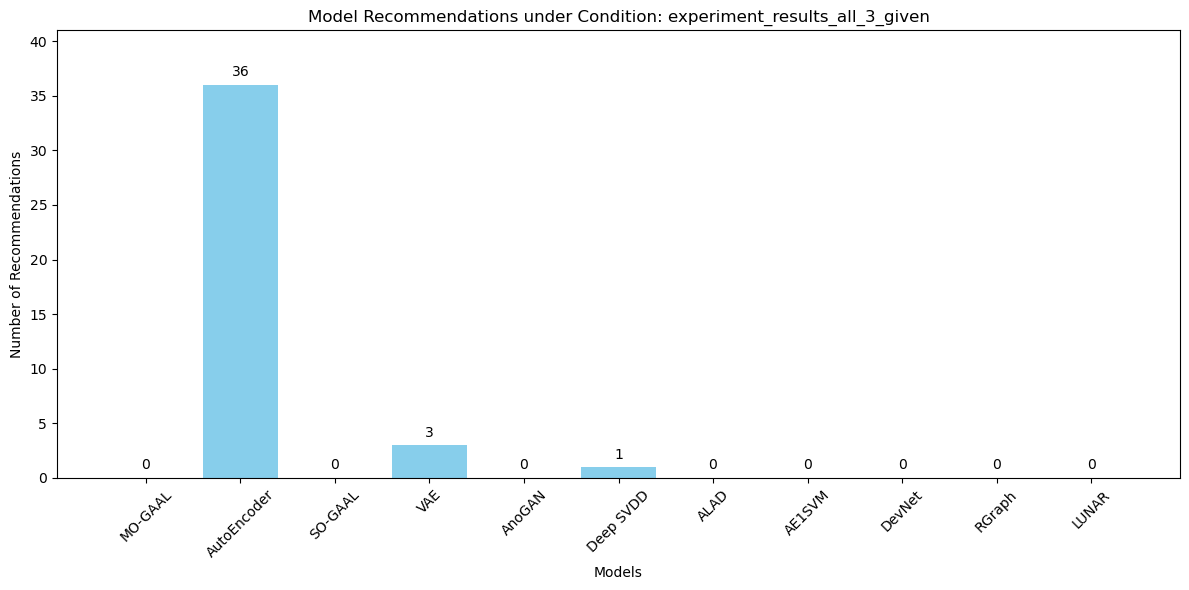


Condition: experiment_results_code_summaries_only
Model recommendation counts:
  MO-GAAL: 0
  AutoEncoder: 37
  SO-GAAL: 0
  VAE: 0
  AnoGAN: 0
  Deep SVDD: 3
  ALAD: 0
  AE1SVM: 0
  DevNet: 0
  RGraph: 0
  LUNAR: 0


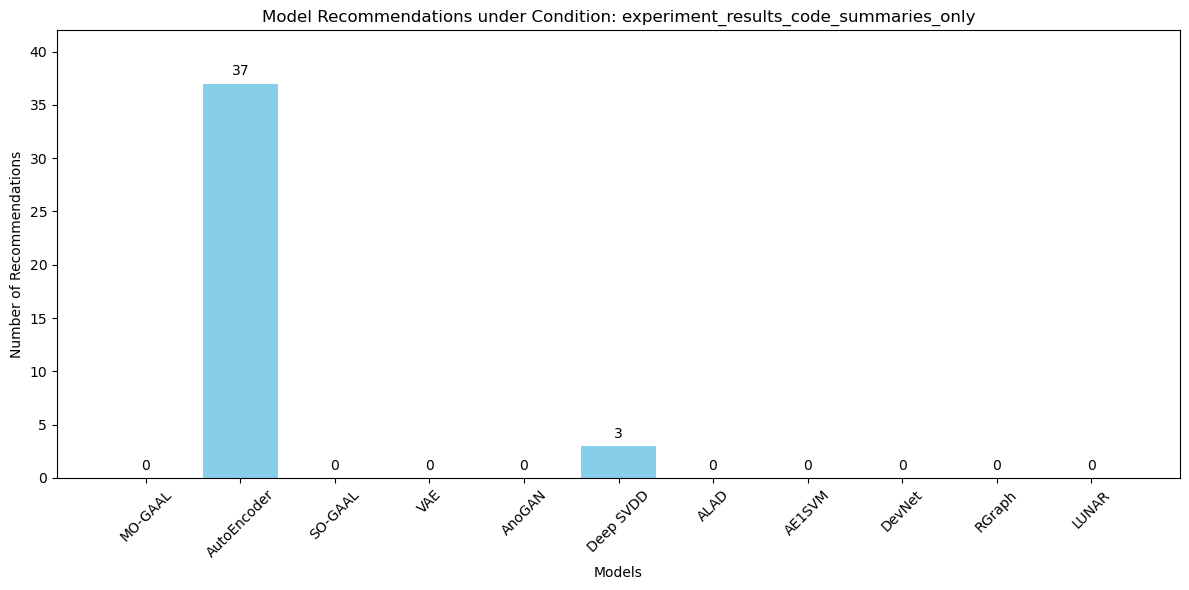


Condition: experiment_results_df_hp_and_code_summaries
Model recommendation counts:
  MO-GAAL: 0
  AutoEncoder: 34
  SO-GAAL: 0
  VAE: 3
  AnoGAN: 0
  Deep SVDD: 3
  ALAD: 0
  AE1SVM: 0
  DevNet: 0
  RGraph: 0
  LUNAR: 0


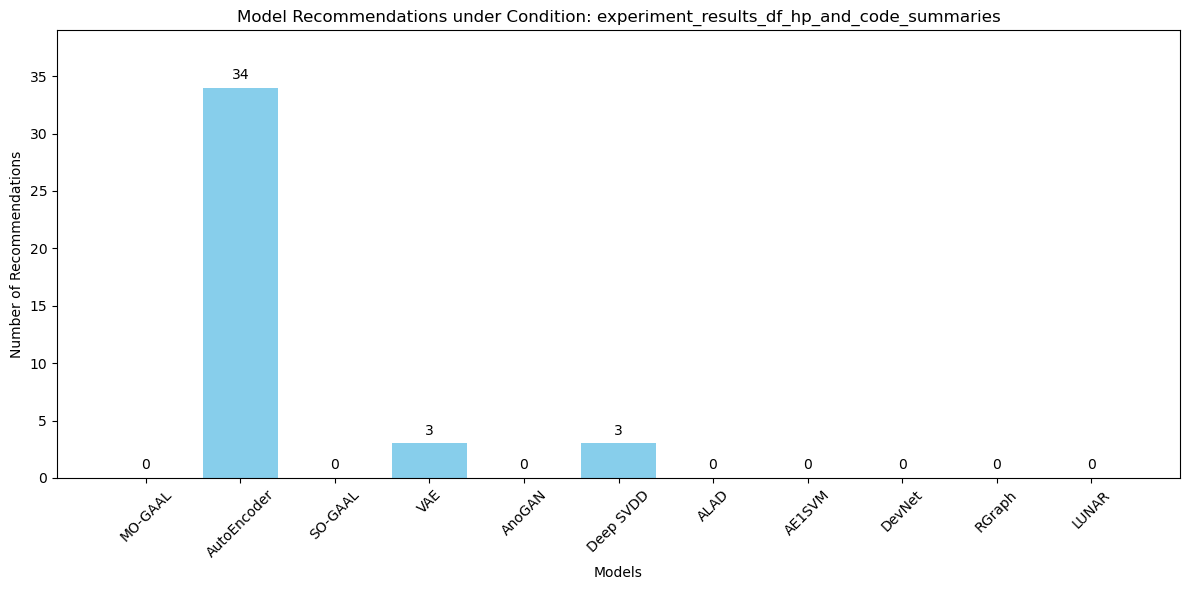


Condition: experiment_results_df_hp_and_paper_summaries
Model recommendation counts:
  MO-GAAL: 0
  AutoEncoder: 34
  SO-GAAL: 0
  VAE: 3
  AnoGAN: 0
  Deep SVDD: 3
  ALAD: 0
  AE1SVM: 0
  DevNet: 0
  RGraph: 0
  LUNAR: 0


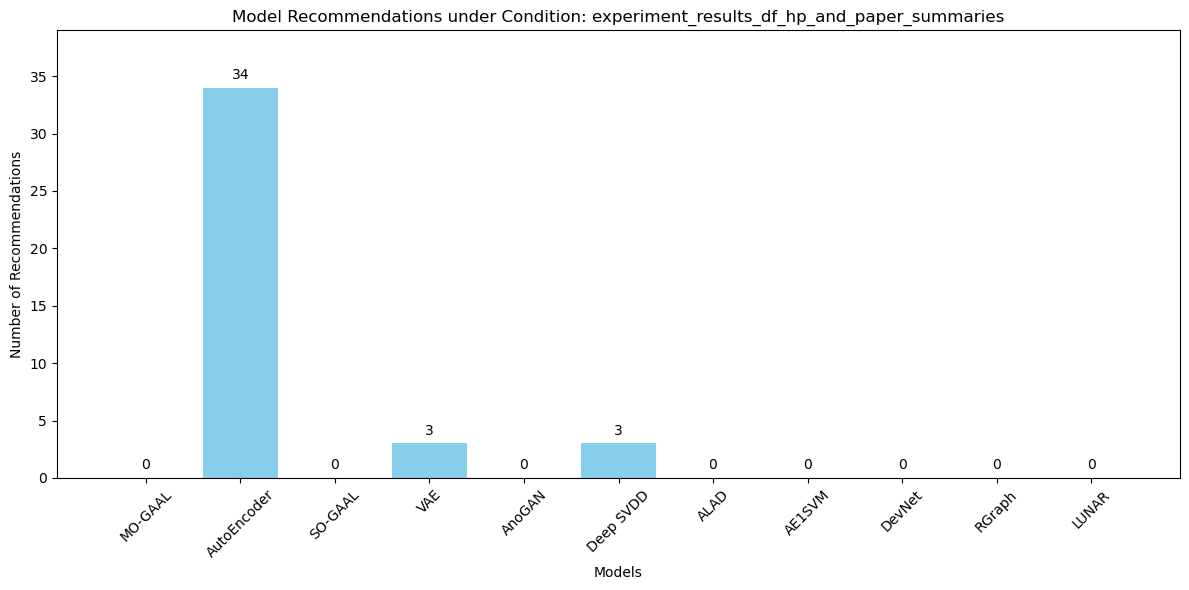


Condition: experiment_results_df_hyperparams_only
Model recommendation counts:
  MO-GAAL: 0
  AutoEncoder: 31
  SO-GAAL: 0
  VAE: 2
  AnoGAN: 0
  Deep SVDD: 7
  ALAD: 0
  AE1SVM: 0
  DevNet: 0
  RGraph: 0
  LUNAR: 0


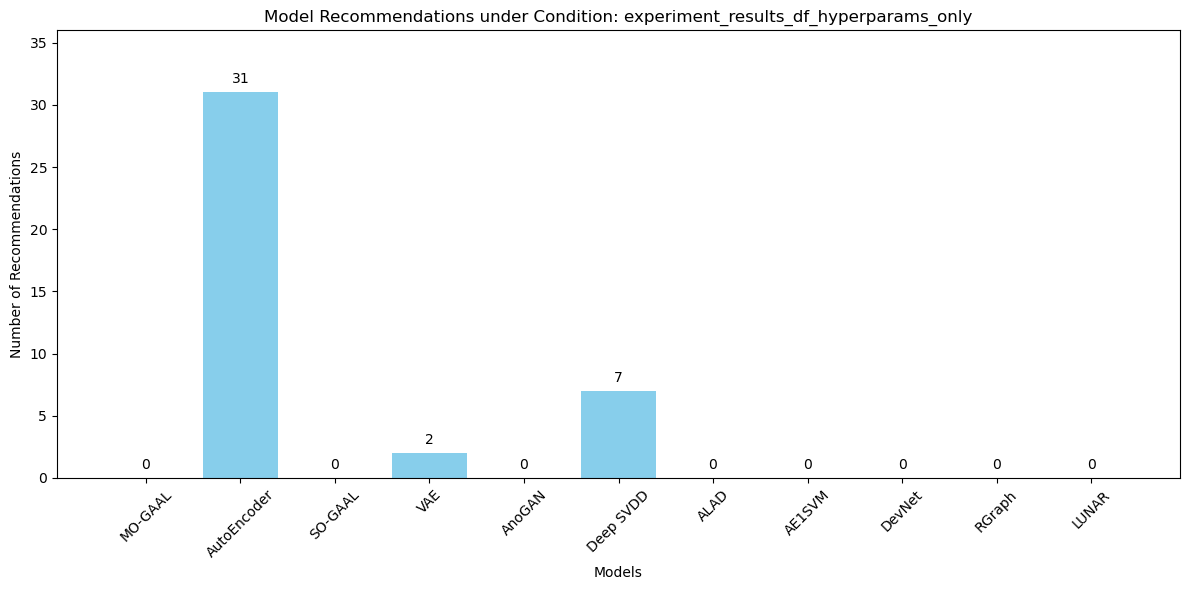


Condition: experiment_results_paper_and_code_summaries
Model recommendation counts:
  MO-GAAL: 0
  AutoEncoder: 37
  SO-GAAL: 0
  VAE: 0
  AnoGAN: 0
  Deep SVDD: 2
  ALAD: 0
  AE1SVM: 0
  DevNet: 1
  RGraph: 0
  LUNAR: 0


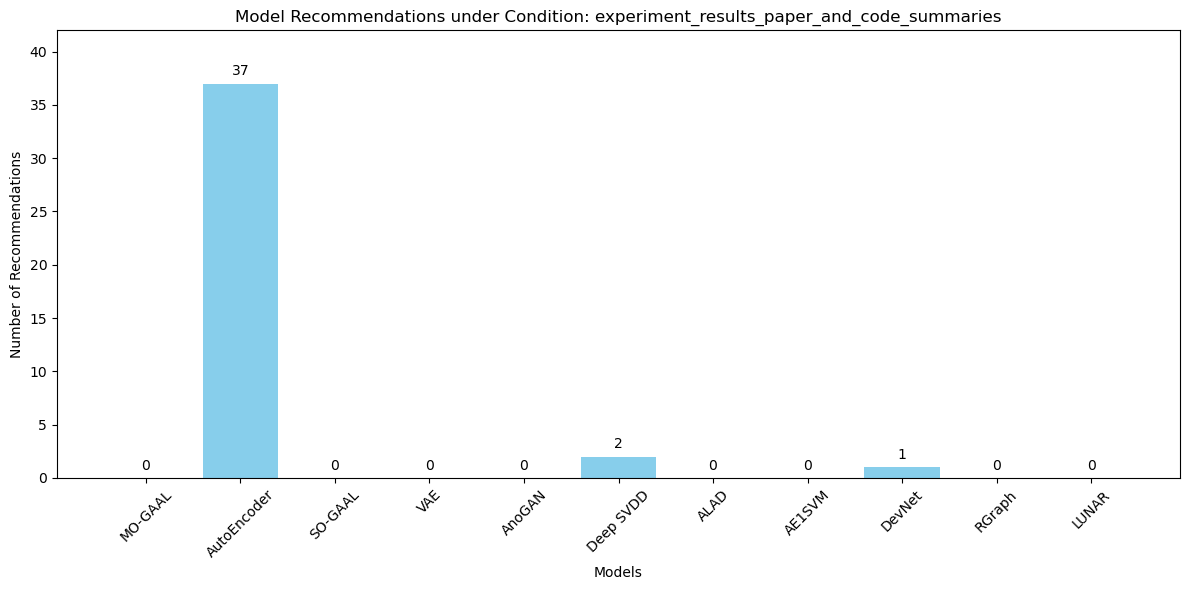


Condition: experiment_results_paper_summaries_only
Model recommendation counts:
  MO-GAAL: 0
  AutoEncoder: 36
  SO-GAAL: 0
  VAE: 0
  AnoGAN: 0
  Deep SVDD: 4
  ALAD: 0
  AE1SVM: 0
  DevNet: 0
  RGraph: 0
  LUNAR: 0


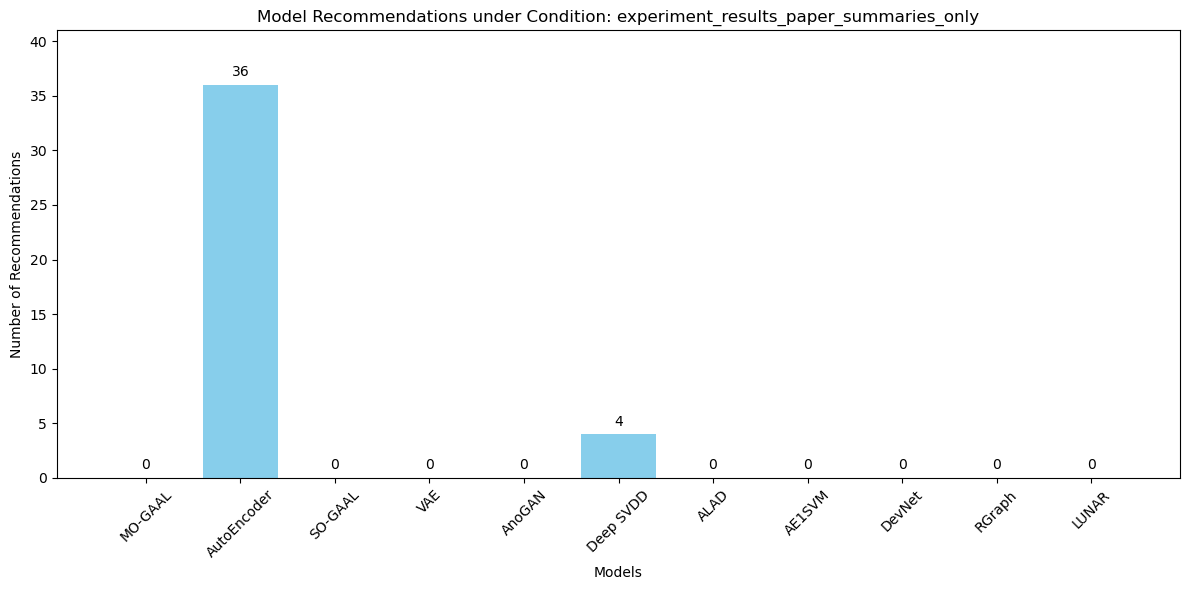


Condition: experiment_results_zero_shot
Model recommendation counts:
  MO-GAAL: 1
  AutoEncoder: 27
  SO-GAAL: 1
  VAE: 4
  AnoGAN: 0
  Deep SVDD: 5
  ALAD: 0
  AE1SVM: 1
  DevNet: 0
  RGraph: 1
  LUNAR: 0


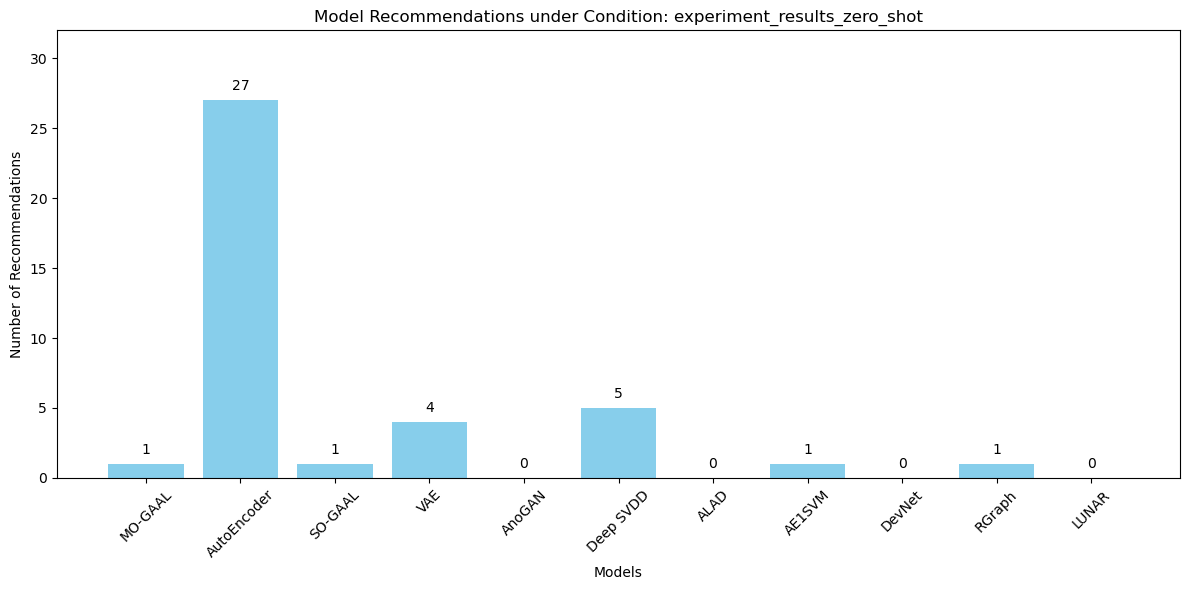

In [ ]:
import re
from collections import Counter

model_list = ['MO-GAAL', 'AutoEncoder', 'SO-GAAL', 'VAE', 'AnoGAN', 'Deep SVDD', 'ALAD', 'AE1SVM', 'DevNet', 'RGraph', 'LUNAR']

for condition, results in experiment_results.items():
    print(f"\nCondition: {condition}")
    model_counter = Counter()
    for dataset_name, responses in results.items():
        for response in responses:
            answer = response['answer']
            cleaned_answer = re.sub(r'[^a-zA-Z\s]', '', answer)
            cleaned_answer_upper = cleaned_answer.upper()
            for model in model_list:
                model_cleaned = re.sub(r'[^a-zA-Z]', '', model).upper()
                if model_cleaned in cleaned_answer_upper.replace(' ', ''):
                    model_counter[model] += 1
    print("Model recommendation counts:")
    for model in model_list:
        count = model_counter.get(model, 0)
        print(f"  {model}: {count}")
    
    models = model_list
    counts = [model_counter.get(model, 0) for model in models]
    
    plt.figure(figsize=(12, 6))
    bars = plt.bar(models, counts, color='skyblue')
    plt.xlabel('Models')
    plt.ylabel('Number of Recommendations')
    plt.title(f'Model Recommendations under Condition: {condition}')
    plt.xticks(rotation=45)
    plt.ylim(0, max(counts) + 5)
    
    for bar, count in zip(bars, counts):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, 
                    str(count), ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()


### Visualize codes